In [1]:
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [6]:
tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
import sys

In [5]:
sys.executable

'/home/nbuser/anaconda3_420/bin/python'

In [1]:
!pip install pandas -U

    100% |################################| 25.7MB 50kB/s eta 0:00:011   48% |###############                 | 12.6MB 533kB/s eta 0:00:25
Requirement already up-to-date: numpy>=1.9.0 in /home/nbcommon/anaconda3_420/lib/python3.5/site-packages (from pandas)
    100% |################################| 194kB 1.7MB/s ta 0:00:01
    100% |################################| 512kB 1.1MB/s ta 0:00:01
  Found existing installation: six 1.10.0
    DEPRECATION: Uninstalling a distutils installed project (six) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    Uninstalling six-1.10.0:
      Successfully uninstalled six-1.10.0
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3
  Found existing installation: pytz 2016.6.1
    DEPRECATION: Uninstalling a distutils installed project (pytz) h

In [2]:
!pip install keras -U

    100% |################################| 307kB 3.9MB/s ta 0:00:011
Requirement already up-to-date: pyyaml in /home/nbcommon/anaconda3_420/lib/python3.5/site-packages (from keras)
    100% |################################| 49.6MB 27kB/s  eta 0:00:01    23% |#######                         | 11.5MB 50.4MB/s eta 0:00:01    46% |###############                 | 23.3MB 45.9MB/s eta 0:00:01
Requirement already up-to-date: numpy>=1.9.1 in /home/nbcommon/anaconda3_420/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /home/nbcommon/anaconda3_420/lib/python3.5/site-packages (from keras)
  Found existing installation: scipy 0.19.0
    Uninstalling scipy-0.19.0:
      Successfully uninstalled scipy-0.19.0
  Found existing installation: Keras 2.0.8
    Uninstalling Keras-2.0.8:
      Successfully uninstalled Keras-2.0.8


In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

In [4]:
import pandas as pd
pd.show_versions()

In [60]:
import numpy as np

# Advanced usage of recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural 
networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will 
demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors 
installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 
24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered 
when working with timeseries.

We will cover the following techniques:

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *Stacking recurrent layers*, to increase the representational power of the network (at the cost of higher computational loads).
* *Bidirectional recurrent layers*, which presents the same information to a recurrent network in different ways, increasing accuracy and 
mitigating forgetting issues.

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence 
data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather 
timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded 
every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is 
perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a 
few days worth of data points) and predicts the air temperature 24 hours in the future.

Let's take a look at the data:

In [15]:
# import os

# data_dir = '/home/ubuntu/data/'
# fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# f = open(fname)
# data = f.read()
# f.close()

# lines = data.split('\n')
# header = lines[0].split(',')
# lines = lines[1:]

# print(header)
# print(len(lines))

In [8]:
df1 = pd.read_csv("https://www.bgc-jena.mpg.de/wetter/mpi_roof_2016b.zip", sep="\,\s*", encoding='cp1252')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [9]:
df1.head()

,"""Date Time""","""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""",...,"""wv (m/s)""","""max. wv (m/s)""","""wd (deg)""","""rain (mm)""","""raining (s)""","""SWDR (W/m²)""","""PAR (µmol/m²/s)""","""max. PAR (µmol/m²/s)""","""Tlog (degC)""","""CO2 (ppm)"""
0,01.07.2016 00:10:00,988.96,17.81,291.90,13.59,76.3,20.43,15.59,4.84,9.86,...,0.63,1.12,76.5,0.0,0.0,0.0,0.0,0.0,28.78,455.0
1,01.07.2016 00:20:00,988.97,17.58,291.66,13.68,77.9,20.13,15.68,4.45,9.92,...,1.06,1.76,134.1,0.0,0.0,0.0,0.0,0.0,28.68,456.0
2,01.07.2016 00:30:00,988.92,17.26,291.35,13.55,78.8,19.73,15.55,4.18,9.84,...,0.97,1.88,200.5,0.0,0.0,0.0,0.0,0.0,28.56,457.6
3,01.07.2016 00:40:00,988.90,17.13,291.22,13.52,79.3,19.57,15.52,4.05,9.82,...,0.87,1.20,207.1,0.0,0.0,0.0,0.0,0.0,28.42,455.3
4,01.07.2016 00:50:00,988.86,16.95,291.04,13.23,78.7,19.35,15.22,4.12,9.63,...,1.24,3.00,225.4,0.0,0.0,0.0,0.0,0.0,28.25,446.0


In [10]:
%%time

dfs = []
for _year in range(2009, 2017):
    for _half in ['a', 'b']:
        _df = pd.read_csv("https://www.bgc-jena.mpg.de/wetter/mpi_roof_{0}{1}.zip".format(_year, _half), 
                          sep="\,\s*", encoding='cp1252')
        dfs.append(_df)
        print(_year, _half, _df.shape)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


2009 a (26064, 22)
2009 b (26494, 22)
2010 a (26208, 22)
2010 b (26496, 22)
2011 a (26064, 22)
2011 b (26496, 22)
2012 a (26208, 22)
2012 b (26496, 22)
2013 a (26063, 22)
2013 b (26496, 22)
2014 a (26247, 22)
2014 b (26400, 22)
2015 a (26064, 22)
2015 b (26496, 22)
2016 a (26208, 22)
2016 b (26051, 22)
CPU times: user 9.81 s, sys: 145 ms, total: 9.95 s
Wall time: 16min 43s


In [29]:
%%time
df = pd.concat(dfs)

CPU times: user 19 ms, sys: 28.1 ms, total: 47.1 ms
Wall time: 49.8 ms


In [31]:
df[::720].head(10)

,"""Date Time""","""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)""","""rain (mm)""","""raining (s)""","""SWDR (W/m²)""","""PAR (µmol/m²/s)""","""max. PAR (µmol/m²/s)""","""Tlog (degC)""","""CO2 (ppm)"""
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30,0.0,0.0,0.0,0.0,0.0,7.20,434.4
720,06.01.2009 00:10:00,997.62,-12.78,260.56,-15.17,82.1,2.28,1.87,0.41,1.17,1.88,1333.76,1.37,2.63,7.26,0.0,0.0,0.0,0.0,0.0,9.51,403.9
1440,11.01.2009 00:10:00,1002.56,-10.68,262.29,-11.69,92.2,2.70,2.49,0.21,1.55,2.48,1329.33,0.47,1.13,149.30,0.0,0.0,0.0,0.0,0.0,9.45,429.0
2160,16.01.2009 00:10:00,997.60,-4.04,269.31,-4.33,97.8,4.53,4.43,0.10,2.76,4.44,1289.15,1.17,1.63,143.00,0.0,0.0,0.0,0.0,0.0,11.99,429.7
2880,21.01.2009 00:10:00,977.48,-3.06,271.87,-3.68,95.4,4.87,4.65,0.22,2.96,4.76,1258.41,0.54,1.88,143.20,0.0,0.0,0.0,0.0,0.0,11.78,413.7
3600,26.01.2009 00:10:00,975.15,-3.28,271.83,-3.85,95.8,4.79,4.59,0.20,2.93,4.71,1256.48,0.85,1.63,191.20,0.0,0.0,0.0,0.0,0.0,11.02,409.0
4320,31.01.2009 00:10:00,997.40,-2.50,270.86,-4.01,89.3,5.08,4.54,0.54,2.83,4.55,1281.53,2.13,3.25,39.53,0.0,0.0,0.0,0.0,0.0,9.65,404.4
5040,05.02.2009 00:10:00,972.46,0.63,275.99,-0.03,95.3,6.40,6.10,0.30,3.91,6.27,1234.38,1.25,2.38,188.10,0.0,600.0,0.0,0.0,0.0,14.35,439.3
5760,10.02.2009 00:10:00,973.37,-0.10,275.18,-3.52,77.6,6.07,4.71,1.36,3.01,4.84,1239.50,2.48,3.50,182.50,0.0,300.0,0.0,0.0,0.0,13.28,405.1
6480,15.02.2009 00:10:00,1000.51,-5.37,267.75,-7.43,85.3,4.09,3.49,0.60,2.17,3.49,1299.83,1.80,2.25,261.90,0.0,0.0,0.0,0.0,0.0,11.30,402.7


In [32]:
df.shape

(420551, 22)

In [14]:
df.to_csv('jena_climate_2009_2016.csv', index=None)

In [34]:
df.set_index('"Date Time"', inplace=True)
df.head(2)

,"""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)""","""rain (mm)""","""raining (s)""","""SWDR (W/m²)""","""PAR (µmol/m²/s)""","""max. PAR (µmol/m²/s)""","""Tlog (degC)""","""CO2 (ppm)"""
"""Date Time""",,,,,,,,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,0.0,0.0,0.0,0.0,0.0,7.20,434.4
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,0.0,0.0,0.0,0.0,0.0,7.15,436.2


<IPython.core.display.Javascript object>


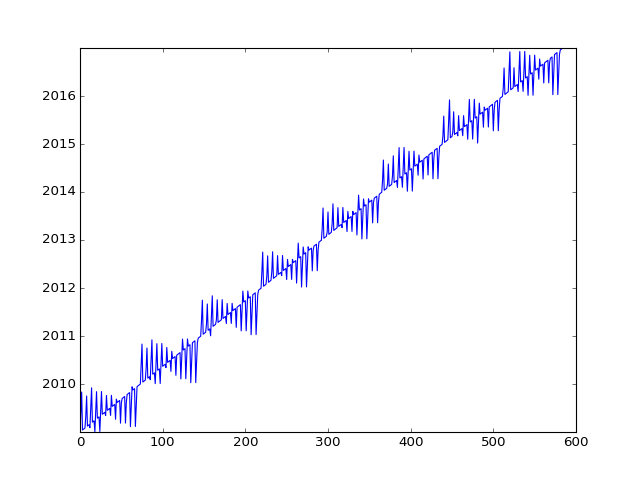

In [37]:
plt.figure()
plt.plot(pd.to_datetime(df.index[::720]))

<IPython.core.display.Javascript object>


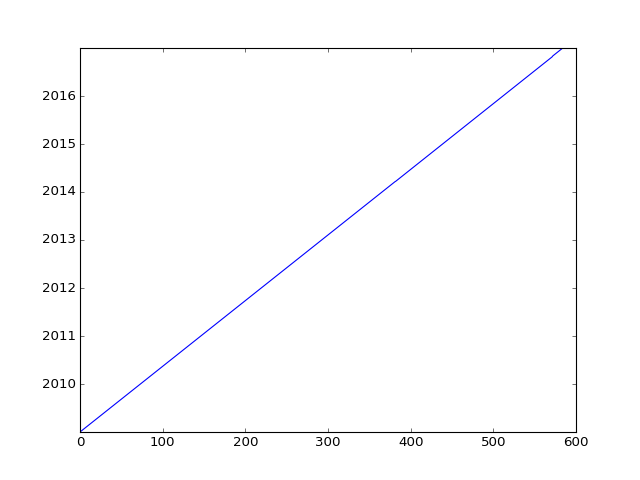

In [39]:
plt.figure()
plt.plot(pd.to_datetime(df.index[::720], dayfirst=True, infer_datetime_format=True))

In [40]:
%%time
df.index=pd.to_datetime(df.index, dayfirst=True, infer_datetime_format=True)

CPU times: user 1.98 s, sys: 0 ns, total: 1.98 s
Wall time: 2.01 s


Let's convert all of these 420,551 lines of data into a Numpy array:

In [43]:
df[::1440].head()

,"""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)""","""rain (mm)""","""raining (s)""","""SWDR (W/m²)""","""PAR (µmol/m²/s)""","""max. PAR (µmol/m²/s)""","""Tlog (degC)""","""CO2 (ppm)"""
"""Date Time""",,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30,0.0,0.0,0.0,0.0,0.0,7.20,434.4
2009-01-11 00:10:00,1002.56,-10.68,262.29,-11.69,92.2,2.70,2.49,0.21,1.55,2.48,1329.33,0.47,1.13,149.30,0.0,0.0,0.0,0.0,0.0,9.45,429.0
2009-01-21 00:10:00,977.48,-3.06,271.87,-3.68,95.4,4.87,4.65,0.22,2.96,4.76,1258.41,0.54,1.88,143.20,0.0,0.0,0.0,0.0,0.0,11.78,413.7
2009-01-31 00:10:00,997.40,-2.50,270.86,-4.01,89.3,5.08,4.54,0.54,2.83,4.55,1281.53,2.13,3.25,39.53,0.0,0.0,0.0,0.0,0.0,9.65,404.4
2009-02-10 00:10:00,973.37,-0.10,275.18,-3.52,77.6,6.07,4.71,1.36,3.01,4.84,1239.50,2.48,3.50,182.50,0.0,300.0,0.0,0.0,0.0,13.28,405.1


In [44]:
# import numpy as np

# float_data = np.zeros((len(lines), len(header) - 1))
# for i, line in enumerate(lines):
#     values = [float(x) for x in line.split(',')[1:]]
#     float_data[i, :] = values

For instance, here is the plot of temperature (in degrees Celsius) over time:

In [45]:
float_data = df.values

In [46]:
float_data

array([[ 996.52,   -8.02,  265.4 , ...,    0.  ,    7.2 ,  434.4 ],
       [ 996.57,   -8.41,  265.01, ...,    0.  ,    7.15,  436.2 ],
       [ 996.53,   -8.51,  264.91, ...,    0.  ,    7.09,  435.1 ],
       ..., 
       [ 999.82,   -3.16,  270.01, ...,    0.  ,    7.21,  428.6 ],
       [ 999.81,   -4.23,  268.94, ...,    0.  ,    7.14,  430.  ],
       [ 999.82,   -4.82,  268.36, ...,    0.  ,    7.08,  432.7 ]])

In [18]:
# from matplotlib import pyplot as plt

# temp = float_data[:, 1]  # temperature (in degrees Celsius)
# plt.plot(range(len(temp)), temp)
# plt.show()

In [19]:
pd.options.display.max_columns=50

In [20]:
df.describe()

,"""p (mbar)""","""T (degC)""","""Tpot (K)""","""Tdew (degC)""","""rh (%)""","""VPmax (mbar)""","""VPact (mbar)""","""VPdef (mbar)""","""sh (g/kg)""","""H2OC (mmol/mol)""","""rho (g/m**3)""","""wv (m/s)""","""max. wv (m/s)""","""wd (deg)""","""rain (mm)""","""raining (s)""","""SWDR (W/m²)""","""PAR (µmol/m²/s)""","""max. PAR (µmol/m²/s)""","""Tlog (degC)""","""CO2 (ppm)"""
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738,0.009639,50.162575,122.881737,240.693832,291.966714,21.505132,378.581341
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693,0.104128,157.204619,206.209010,399.738488,521.180595,8.036716,562.157602
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000,0.000000,-9999.000000,0.000000,0.000000,-9999.000000,4.310000,-9999.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000,0.000000,0.000000,0.000000,0.000000,0.000000,15.350000,395.800000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000,0.000000,0.000000,2.410000,7.920000,10.810000,20.900000,405.900000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000,0.000000,0.000000,164.390000,327.610000,387.450000,27.060000,419.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000,14.000000,600.000000,1219.320000,2401.540000,2500.000000,50.470000,586.000000


In [21]:
from matplotlib import pyplot as plt
%matplotlib notebook

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


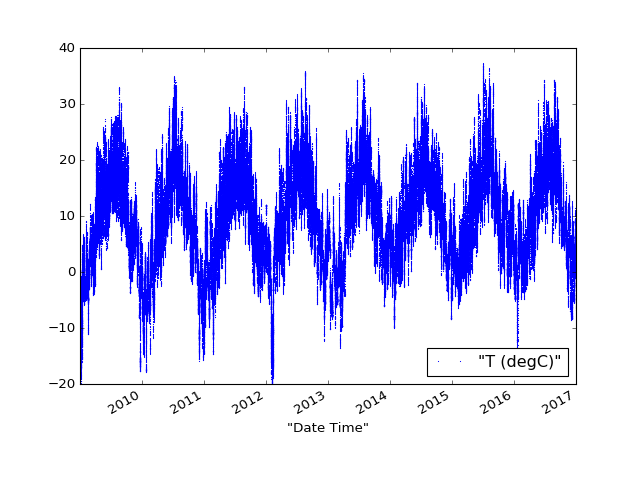

In [47]:
df[[df.columns[1]]].plot(ylim=[-20,40], style='.', markersize=1)

<IPython.core.display.Javascript object>


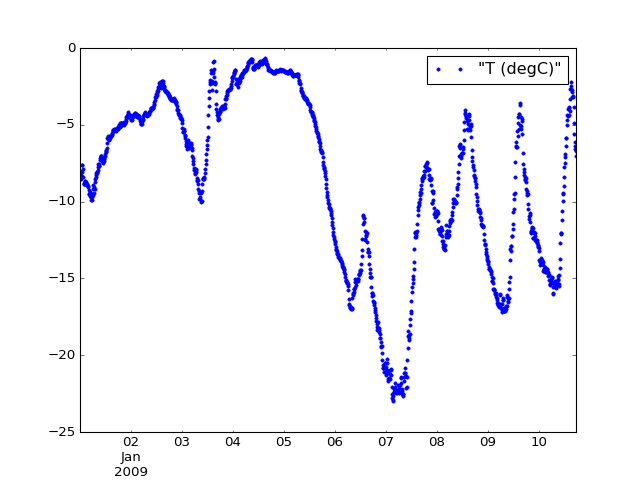

In [48]:
df[[df.columns[1]]][:1400].plot(style='.')


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

In [49]:
#plt.plot(range(1440), temp[:1440])
#plt.show()


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be 
coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is 
this timeseries predictable at a daily scale? Let's find out.

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [50]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [51]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [54]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [55]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

In [56]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

In [57]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [58]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline


Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for 
which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more 
common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the 
temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 
24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 
Mean Absolute Error is simply equal to:

```python
np.mean(np.abs(preds - targets))
```

Here's our evaluation loop:

In [62]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [63]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 34ms/step - loss: 1.2374 - val_loss: 0.6196
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.4840 - val_loss: 0.3309
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3683 - val_loss: 0.7151
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2916 - val_loss: 0.3464
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2576 - val_loss: 0.3125
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3118 - val_loss: 0.3201
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2421 - val_loss: 0.3256
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2284 - val_loss: 0.3131
Epoch 9/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2424 - val_loss: 0.3594
Epoch 10/20
500/500 [==============================] - 17s 33ms/step - loss: 0.327

Let's display the loss curves for validation and training:

<IPython.core.display.Javascript object>


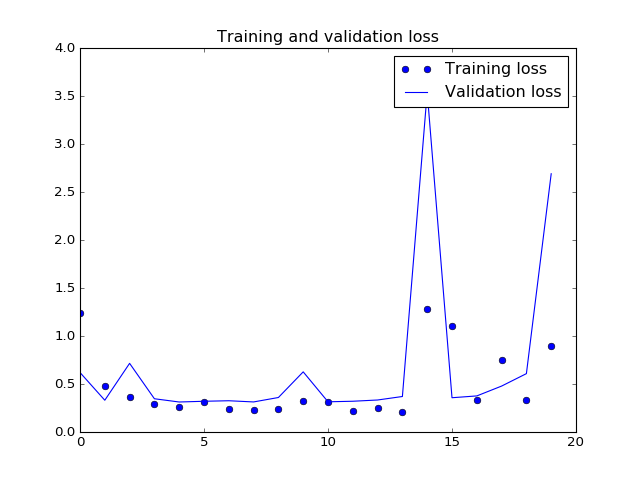

In [64]:
#import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [66]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 122s 244ms/step - loss: 0.3008 - val_loss: 0.2680
Epoch 2/20
500/500 [==============================] - 202s 403ms/step - loss: 0.2719 - val_loss: 0.2629
Epoch 3/20
500/500 [==============================] - 201s 402ms/step - loss: 0.2652 - val_loss: 0.2589
Epoch 4/20
500/500 [==============================] - 204s 408ms/step - loss: 0.2573 - val_loss: 0.2605
Epoch 5/20
500/500 [==============================] - 189s 379ms/step - loss: 0.2541 - val_loss: 0.2634
Epoch 6/20
500/500 [==============================] - 185s 370ms/step - loss: 0.2512 - val_loss: 0.2609
Epoch 7/20
500/500 [==============================] - 185s 370ms/step - loss: 0.2434 - val_loss: 0.2615
Epoch 8/20
500/500 [==============================] - 189s 378ms/step - loss: 0.2399 - val_loss: 0.2639
Epoch 9/20
500/500 [==============================] - 185s 370ms/step - loss: 0.2365 - val_loss: 0.2651
Epoch 10/20
500/500 [==============================] - 187s 373m

Let look at our results:

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after 
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [69]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 87s 175ms/step - loss: 0.3312 - val_loss: 0.2669
Epoch 2/40
500/500 [==============================] - 87s 174ms/step - loss: 0.3022 - val_loss: 0.2688
Epoch 3/40
500/500 [==============================] - 87s 175ms/step - loss: 0.2950 - val_loss: 0.2708
Epoch 4/40
500/500 [==============================] - 87s 175ms/step - loss: 0.2896 - val_loss: 0.2645
Epoch 5/40
500/500 [==============================] - 87s 175ms/step - loss: 0.2868 - val_loss: 0.2631
Epoch 6/40
500/500 [==============================] - 101s 201ms/step - loss: 0.2845 - val_loss: 0.2568
Epoch 7/40
500/500 [==============================] - 87s 174ms/step - loss: 0.2804 - val_loss: 0.2588
Epoch 8/40
500/500 [==============================] - 87s 175ms/step - loss: 0.2789 - val_loss: 0.2660
Epoch 9/40
500/500 [==============================] - 89s 178ms/step - loss: 0.2776 - val_loss: 0.2619
Epoch 10/40
500/500 [==============================] - 87s 174ms/step - 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 237s 475ms/step - loss: 0.3129 - val_loss: 0.2659
Epoch 2/40
500/500 [==============================] - 239s 477ms/step - loss: 0.2936 - val_loss: 0.2649
Epoch 3/40
500/500 [==============================] - 237s 474ms/step - loss: 0.2841 - val_loss: 0.2705
Epoch 4/40
500/500 [==============================] - 228s 456ms/step - loss: 0.2804 - val_loss: 0.2654
Epoch 5/40
500/500 [==============================] - 223s 446ms/step - loss: 0.2761 - val_loss: 0.2596
Epoch 6/40
500/500 [==============================] - 237s 474ms/step - loss: 0.2711 - val_loss: 0.2651
Epoch 7/40
500/500 [==============================] - 238s 476ms/step - loss: 0.2674 - val_loss: 0.2661
Epoch 8/40
500/500 [==============================] - 237s 475ms/step - loss: 0.2630 - val_loss: 0.2707
Epoch 9/40
500/500 [==============================] - 233s 467ms/step - loss: 0.2606 - val_loss: 0.2634
Epoch 10/40
500/500 [==============================] - 218s 436m

Let's take a look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss 
improvement. This does have a non-negligible computational cost, though. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this 
point.

## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which 
can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it 
the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 205s 410ms/step - loss: 0.4624 - val_loss: 0.4634
Epoch 2/20
500/500 [==============================] - 217s 435ms/step - loss: 0.4051 - val_loss: 0.4568
Epoch 3/20
500/500 [==============================] - 216s 433ms/step - loss: 0.3555 - val_loss: 0.4573
Epoch 4/20
500/500 [==============================] - 220s 441ms/step - loss: 0.3323 - val_loss: 0.4605
Epoch 5/20
500/500 [==============================] - 221s 443ms/step - loss: 0.3147 - val_loss: 0.4506
Epoch 6/20
500/500 [==============================] - 214s 428ms/step - loss: 0.2962 - val_loss: 0.4493
Epoch 7/20
500/500 [==============================] - 184s 369ms/step - loss: 0.2832 - val_loss: 0.4427
Epoch 8/20
500/500 [==============================] - 197s 394ms/step - loss: 0.2726 - val_loss: 0.4416
Epoch 9/20
500/500 [==============================] - 198s 397ms/step - loss: 0.2632 - val_loss: 0.4456
Epoch 10/20
500/500 [==============================] - 196s 393m

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very 
important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the 
recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our 
problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is 
bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural 
language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's 
try the same trick on the LSTM IMDB example from the previous section:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our 
hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained 
on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would 
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and 
you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the 
more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other 
approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will 
introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both 
ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to 
overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some 
regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the 
chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because 
the recent past matters much more than the distant past in this case).


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


## Wrapping up

Here's what you should take away from this section:

* As you first learned in Chapter 4, when approaching a new problem, 
it is good to first establish common sense baselines for your metric of choice. If you don't have a 
baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal 
data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras 
recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. 
While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not 
be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be 
especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will 
leave them for future study outside of this book.